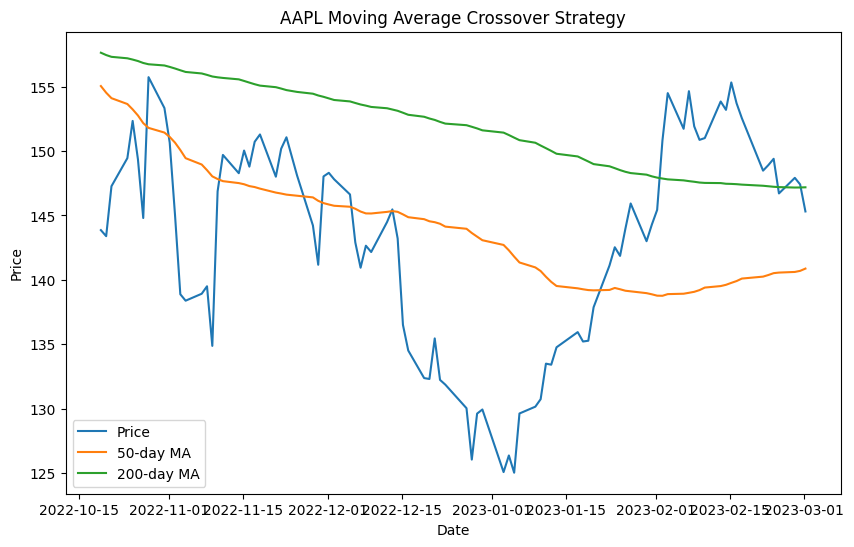

Number of trades: 45
Win rate: 51.11%
Return rate: -4.50%
Total profit: $-6.48


In [1]:
import alpaca_trade_api as tradeapi
import pandas as pd
import matplotlib.pyplot as plt
import os

# Set your Alpaca API key and secret
# API_KEY = ''
# API_SECRET = ''
API_KEY=os.getenv('API_KEY')
SECRET_KEY=os.getenv('SECRET_KEY')
BASE_URL = 'https://paper-api.alpaca.markets'

# Connect to Alpaca API
api = tradeapi.REST(API_KEY, SECRET_KEY, base_url=BASE_URL, api_version='v2')

# Define the moving average crossover strategy
def moving_average_crossover_strategy(SYMBOL, INTERVAL, short_term, long_term):
    # Get historical data from Alpaca
    start_date = pd.Timestamp('2022-01-01', tz='America/New_York').isoformat()
    end_date = pd.Timestamp('2023-03-01', tz='America/New_York').isoformat()
    barset = api.get_bars(symbol=SYMBOL, timeframe=INTERVAL, start=start_date, end=end_date)
    prices = barset.df['close']

    # Calculate the moving averages
    short_ma = prices.rolling(window=short_term).mean()
    long_ma = prices.rolling(window=long_term).mean()

    # Initialize variables for tracking positions and PnL
    position = 0  # 0 - No position, 1 - Long position, -1 - Short position
    pnl = 0.0
    trades = []

    # Iterate over the historical data
    for i in range(long_term, len(prices)):
        if short_ma[i] > long_ma[i] and position <= 0:  # Buy signal
            position = 1
            entry_price = prices[i]
        elif short_ma[i] < long_ma[i] and position >= 0:  # Sell signal
            position = -1
            entry_price = prices[i]
        elif short_ma[i] < long_ma[i] and position == -1:  # Cover signal
            position = 0
            exit_price = prices[i]
            pnl += entry_price - exit_price
            trades.append((exit_price - entry_price) / entry_price)
        elif short_ma[i] > long_ma[i] and position == 1:  # Sell signal
            position = 0
            exit_price = prices[i]
            pnl += exit_price - entry_price
            trades.append((exit_price - entry_price) / entry_price)

    # Calculate the strategy performance
    num_trades = len(trades)
    win_rate = sum([1 for trade in trades if trade > 0]) / num_trades if num_trades > 0 else 0.0
    return_rate = pnl / prices[long_term]
    total_profit = pnl

    # Plotting the strategy performance
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(prices.index[long_term:], prices[long_term:], label='Price')
    ax.plot(prices.index[long_term:], short_ma[long_term:], label=f'{short_term}-day MA')
    ax.plot(prices.index[long_term:], long_ma[long_term:], label=f'{long_term}-day MA')
    ax.legend()
    ax.set_xlabel('Date')
    ax.set_ylabel('Price')
    ax.set_title(f'{SYMBOL} Moving Average Crossover Strategy')
    plt.show()

    return num_trades, win_rate, return_rate, total_profit

# Define the parameters
SYMBOL = 'AAPL'  # Equity symbol to test the strategy on
INTERVAL = '1D'
short_term = 50  # Short-term moving average period
long_term = 200  # Long-term moving average period

# Run the strategy
num_trades, win_rate, return_rate, total_profit = moving_average_crossover_strategy(SYMBOL, INTERVAL, short_term, long_term)

# Print the results
print(f"Number of trades: {num_trades}")
print(f"Win rate: {win_rate:.2%}")
print(f"Return rate: {return_rate:.2%}")
print(f"Total profit: ${total_profit:.2f}")